# Quantum Nearest Neighbour: distance based classifier
## References: 
* Classifier: Implementing a distance-based classifier with a quantum interference circuit, M. Schuld et al 2017 EPL 119 60002

# Preparing the data

In [1]:
import numpy as np
import pandas as pd

In [2]:
iris = pd.read_csv("input_files/iris.data",header=None,names=["f0","f1","f2","f3","class"])

In [3]:
setosa = iris[iris["class"] == "Iris-setosa"].loc[:,["f0","f1","class"]]
# setosa.loc[:,"class"] = -1
setosa["color"] = "Red"
setosa["marker"] = "o"

versicolor = iris[iris["class"] == "Iris-versicolor"].loc[:,["f0","f1","class"]]
# versicolor.loc[:,"class"] = 1
versicolor["color"] = "Blue"
versicolor["marker"] = "x"

virginica = iris[iris["class"] == "Iris-virginica"].loc[:,["f0","f1","class"]]
# virginica.loc[:,"class"] = 1
virginica["color"] = "Green"
virginica["marker"] = "."

In [4]:
data = pd.concat([setosa,versicolor])
# data = pd.concat([versicolor,virginica])
# data = pd.concat([setosa,versicolor,virginica])

In [5]:
import matplotlib.pyplot as plt
plt.scatter(data.to_numpy()[:50,0], data.to_numpy()[:50,1], color="red", marker="o", label="setosa")
plt.scatter(data.to_numpy()[50:100,0], data.to_numpy()[50:100,1], color="blue", marker="x", label="versicolor")

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data.iloc[:,[0,1]] = scaler.fit_transform(data.iloc[:,[0,1]])

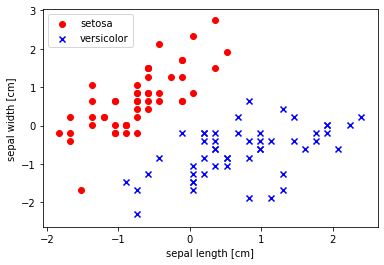

In [7]:
plt.scatter(data.to_numpy()[:50,0], data.to_numpy()[:50,1], color="red", marker="o", label="setosa")
plt.scatter(data.to_numpy()[50:100,0], data.to_numpy()[50:100,1], color="blue", marker="x", label="versicolor")

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

plt.show()

In [8]:
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
       return v
    return v / norm

In [9]:
for i in data.index:
    v = [data.loc[i,"f0"],data.loc[i,"f1"]]
    v = normalize(v)
    data.loc[i,"f0"], data.loc[i,"f1"] = v[0], v[1]

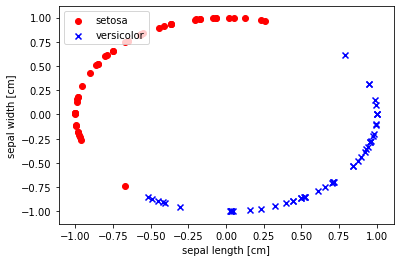

In [10]:
plt.scatter(data.to_numpy()[:50,0], data.to_numpy()[:50,1], color="red", marker="o", label="setosa")
plt.scatter(data.to_numpy()[50:100,0], data.to_numpy()[50:100,1], color="blue", marker="x", label="versicolor")

plt.xlabel('sepal length [cm]')
plt.ylabel('sepal width [cm]')
plt.legend(loc='upper left')

plt.show()

In [11]:
setosa.head()

,f0,f1,class,color,marker
0,5.1,3.5,Iris-setosa,Red,o
1,4.9,3.0,Iris-setosa,Red,o
2,4.7,3.2,Iris-setosa,Red,o
3,4.6,3.1,Iris-setosa,Red,o
4,5.0,3.6,Iris-setosa,Red,o


In [12]:
# For setosa and versicolor
vectors = data.loc[[33,85,28,56],["f0","f1","class"]]
vectors["label"], vectors["angle"] = ["x0 (t0)","x1 (t1)","x' (x0)","x'' (x1)"], [round(np.pi,3),1.325,4.304,3.036]
vectors

# For versicolor and virginica
# vectors = data.loc[[50,145,53,149],["f0","f1","class"]]
# vectors["label"] = ["t0","t1","x0","x1"]
# vectors

,f0,f1,class,label,angle
33,0.019449,0.999811,Iris-setosa,x0 (t0),3.142
85,0.788610,0.614894,Iris-versicolor,x1 (t1),1.325
28,-0.549104,0.835754,Iris-setosa,x' (x0),4.304
56,0.948221,0.317610,Iris-versicolor,x'' (x1),3.036


In [13]:
f0 = vectors.columns.get_loc("f0")
f1 = vectors.columns.get_loc("f1")
t0 = np.arctan(vectors.iloc[0,f1] / vectors.iloc[0,f0]) * 2 % (2 * np.pi)
t1 = np.arctan(vectors.iloc[1,f1] / vectors.iloc[1,f0]) * 2 % (2 * np.pi)
x0 = np.arctan(vectors.iloc[2,f1] / vectors.iloc[2,f0]) * 2 % (2 * np.pi)
x1 = np.arctan(vectors.iloc[3,f1] / vectors.iloc[3,f0]) * 2 % (2 * np.pi)

# Building the quantum circuit

In [14]:
import qiskit
from qiskit import IBMQ
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    execute,
    Aer)
from qiskit.visualization import plot_histogram
# import qiskit.aqua.circuits.gates.controlled_ry_gates

In [15]:
str(1+1+1+1) + ' qubits'

'4 qubits'

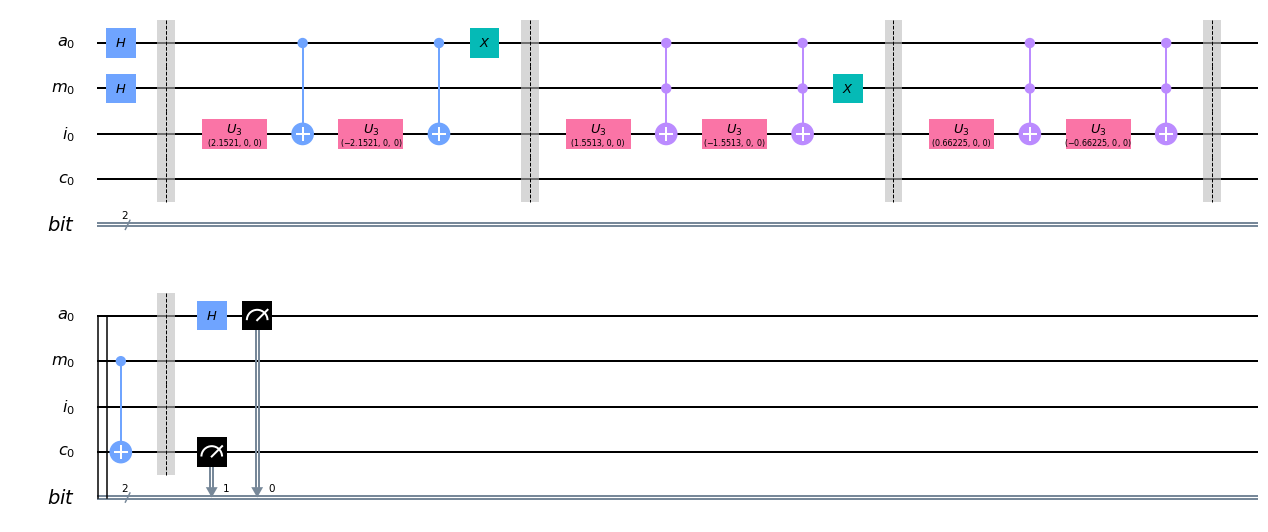

In [16]:
a = QuantumRegister(1,'a')
m = QuantumRegister(1,'m')
i = QuantumRegister(1,'i')
c = QuantumRegister(1,'c')
b = ClassicalRegister(2, 'bit')
circuit = QuantumCircuit(a,m,i,c,b)

circuit.h(a)
circuit.h(m)

circuit.barrier()

circuit.cry(x0,a[0],i[0])
circuit.x(a)

circuit.barrier()

# circuit.ccx(a,m,i)
circuit.mcry(t0,a[:]+m[:],i[0],None)
circuit.x(m)

circuit.barrier()

circuit.mcry(t1,a[:]+m[:],i[0],None)

circuit.barrier()

circuit.cx(m,c)

circuit.barrier()

circuit.h(a)
circuit.measure(a,b[0])
circuit.measure(c,b[1])

circuit.draw(output='mpl')


Total counts are: {'00': 3698, '11': 1941, '01': 362, '10': 2191}


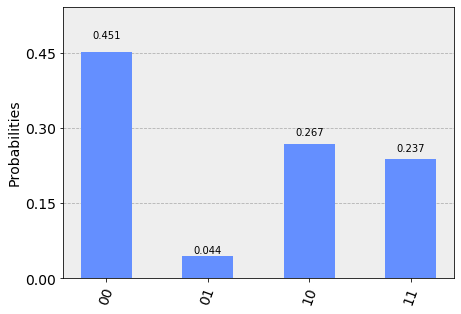

In [17]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(circuit, simulator, shots=8192)
result = job.result()
counts = result.get_counts(circuit)
print("\nTotal counts are:",counts)
plot_histogram(counts)

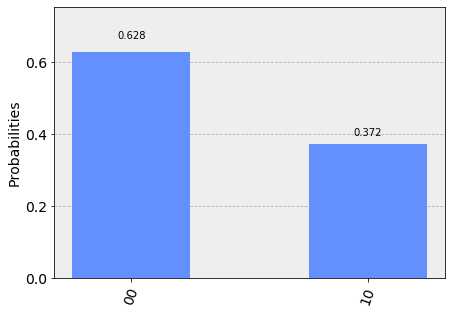

In [18]:
goodCounts = {k: counts[k] for k in counts.keys() & {'00', '10'}}
plot_histogram(goodCounts)